# Comparación de predicciones de series de tiempo de muertes por COVID-19

In [1]:
import pmdarima as pm
import pandas as pd
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('fivethirtyeight')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

## Preparación del dataset

In [2]:
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,2288,2301,2301,2314,2324,2336,2339,2343,2346,2354
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,1247,1252,1256,1261,1265,1270,1277,1281,1287,1291
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,2812,2816,2819,2822,2827,2831,2836,2840,2843,2849
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,85,86,87,88,88,91,91,91,92,92
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,420,422,424,425,428,431,436,439,442,444


In [3]:
d = deaths_df.loc[:, '1/22/20':]
d = d.transpose()
d = d.sum(axis=1)
d = d.to_list()
dataset = pd.DataFrame(columns=['ds', 'y'])
dates = list(deaths_df.columns[4:])
dates = list(pd.to_datetime(dates))
dataset['ds'] = dates
dataset['y'] = d
dataset = dataset.set_index('ds')
dataset.head()

,y
ds,
2020-01-22,17
2020-01-23,18
2020-01-24,26
2020-01-25,42
2020-01-26,56


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-01-22 to 2021-01-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


Text(0.5, 1.0, 'Muertes acumuladas COVID19')

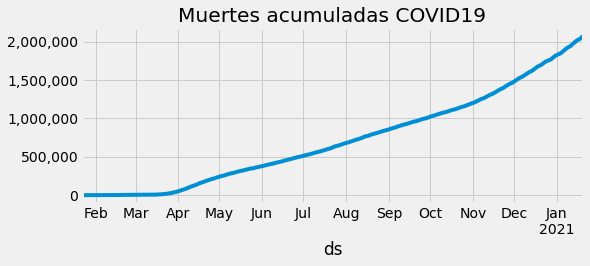

In [5]:
ax = dataset.plot(figsize=(8, 3), legend = None)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title('Muertes acumuladas COVID19')

In [6]:
# Incremento diario. Para hacerlo utilizo el método diff del objeto DataFrame

dataset = dataset.diff()
dataset = dataset.loc['2020-01-23':]
dataset.head()

,y
ds,
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0


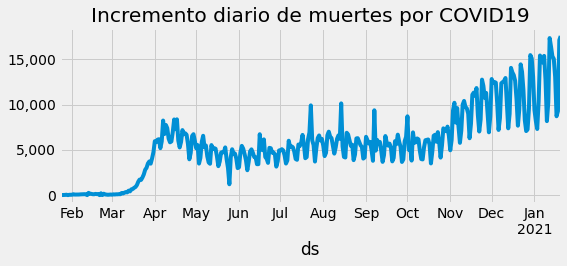

In [7]:
ax = dataset.plot(figsize=(8, 3), legend = None)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title('Incremento diario de muertes por COVID19');

In [8]:
dataset.describe()

,y
count,364.000000
mean,5699.854396
std,3747.580287
min,1.000000
25%,3831.500000
50%,5466.500000
75%,7009.000000
max,17549.000000


## Estacionalidad del dataset

In [9]:
# Identificar estacionalidad

dataset_no_trend = dataset - dataset.rolling(30).mean().dropna()

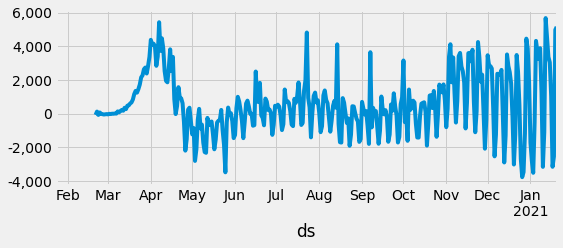

In [10]:
ax = dataset_no_trend.plot(figsize=(8, 3), legend = None)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'));

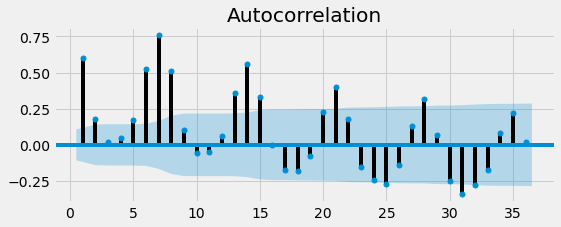

In [11]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
# Plot ACF
plot_acf(dataset_no_trend.dropna(), ax = ax, lags = 36, zero = False)
plt.show()

## Descomposición de la serie de tiempo

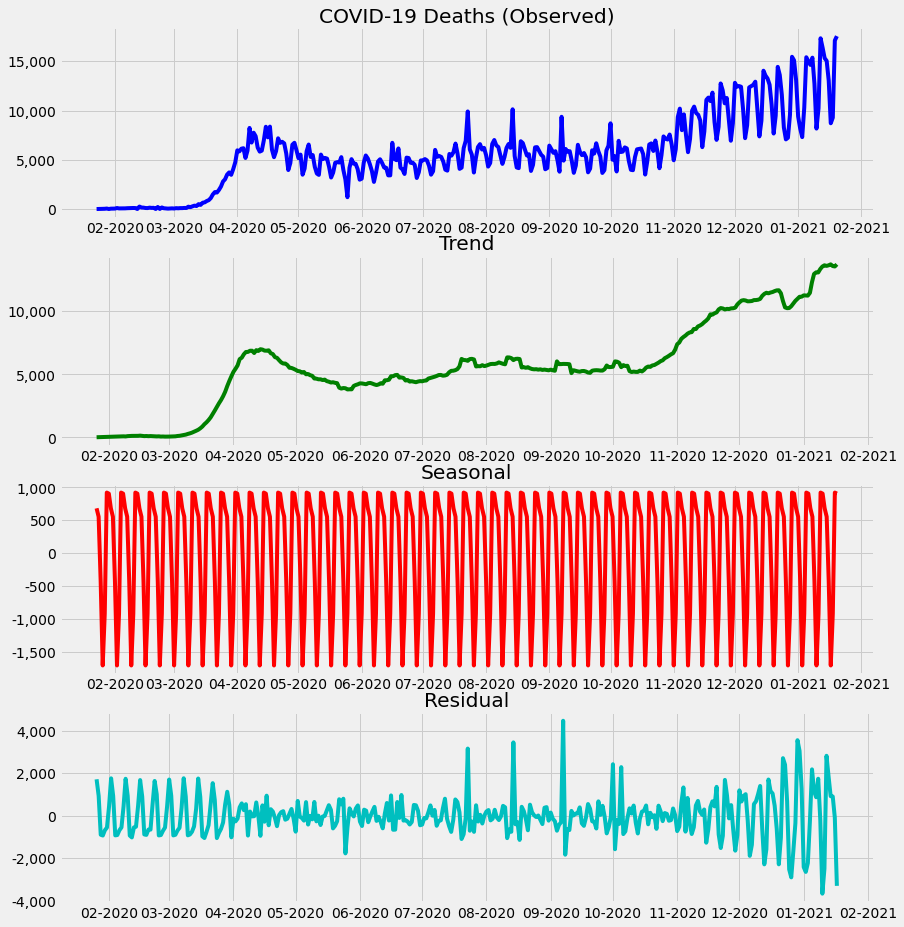

In [12]:
decomposition = seasonal_decompose(dataset)

trend = decomposition.trend
seasonal = decomposition.seasonal
noise = decomposition.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(13, 15))
ax1.plot(dataset, color = 'b')
ax1.title.set_text('COVID-19 Deaths (Observed)')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.plot(trend, color = 'g')
ax2.title.set_text('Trend')
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax3.plot(seasonal, color = 'r')
ax3.title.set_text('Seasonal')
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax3.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax4.plot(noise, color = 'c')
ax4.title.set_text('Residual')
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax4.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

## Estacionariedad del dataset

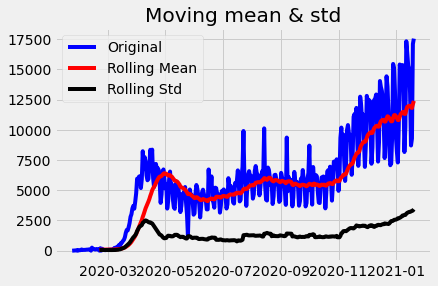

(-0.6458269673863932, 0.8602872344441723, 14, 349, {'1%': -3.449226932880019, '5%': -2.869857365438656, '10%': -2.571201085130664}, 5725.040226463064)
Test Statistic                  -0.645827
p-value                          0.860287
#Lags Used                      14.000000
Number of Observations Used    349.000000
Critical Value (1%)             -3.449227
Critical Value (5%)             -2.869857
Critical Value (10%)            -2.571201
dtype: float64


In [13]:
# Determing rolling statistics
rol_mean = dataset.rolling(window  = 30).mean()
rol_std = dataset.rolling(window = 30).std()

# Plot rolling statistics:
orig = plt.plot(dataset, color = 'blue',label = 'Original')
mean = plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rol_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Moving mean & std')
plt.show(block = False)

# Perform Dickey-Fuller test:
test = adfuller(dataset, autolag = 'AIC')
print(test)

# to make the results of the test more readable
dfoutput = pd.Series(test[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

## Predicción con SARIMAX (Seasonal AutoRegressive Integrated Moving Average with exogenous regressors)

### Determinar p, q y d

In [14]:
# Diferenciación (d)

dataset_diff = dataset.copy()
dataset_diff = dataset_diff.diff()
dataset_diff = dataset_diff.loc['2020-01-24':]

In [15]:
# Dickey-Fuller test

result = adfuller(dataset_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.259302
p-value: 0.000522
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


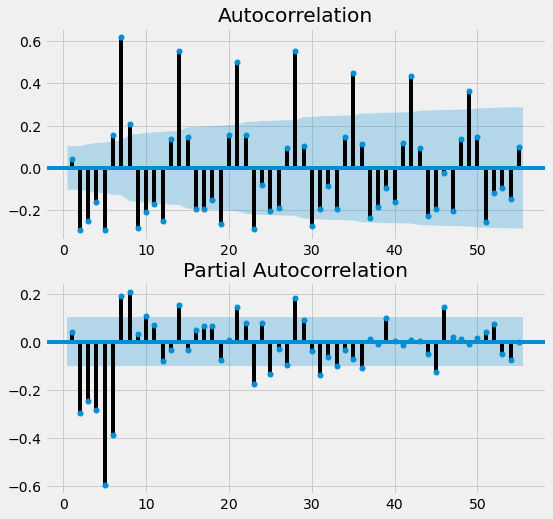

In [16]:
# Non seasonal model orders

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot the ACF of savings on ax1
plot_acf(dataset_diff.y, lags = 55, zero = False, ax = ax1);

# Plot the PACF of savings on ax2
plot_pacf(dataset_diff.y, lags = 55, zero = False, ax = ax2);

### División dataset en train y test sets

In [17]:
train, test = train_test_split(dataset, test_size=12, random_state=42, shuffle=False)
display(train)
display(test)

,y
ds,
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0
...,...
2021-01-04,10290.0
2021-01-05,15408.0
2021-01-06,15016.0


,y
ds,
2021-01-09,12719.0
2021-01-10,8167.0
2021-01-11,10228.0
2021-01-12,17330.0
2021-01-13,16378.0
2021-01-14,15313.0
2021-01-15,15038.0
2021-01-16,13033.0
2021-01-17,8706.0


In [18]:
# buscar la mejor combinación de hiperparámetros con auto_arima

model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',          # use adftest to find optimal 'd'
                      max_p=10, max_q=10,  # maximum p and q
                      m=1,                 # frequency of series
                      d=None,              # let model determine 'd'
                      seasonal=False,      # No Seasonality
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)

print(model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6102.900, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6104.727, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6026.764, Time=0.61 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6012.113, Time=1.20 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=5982.987, Time=1.05 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=5964.181, Time=1.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6104.804, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6021.030, Time=0.83 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6009.755, Time=1.14 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=5966.430, Time=1.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6083.872, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5995.811, Time=0.82 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5905.896, Time=0.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5873.618, Time=1.19 sec
 ARIMA(3,1,0)(0

In [19]:
model = SARIMAX(train, order=(2, 1, 3))
results = model.fit(disp = True)

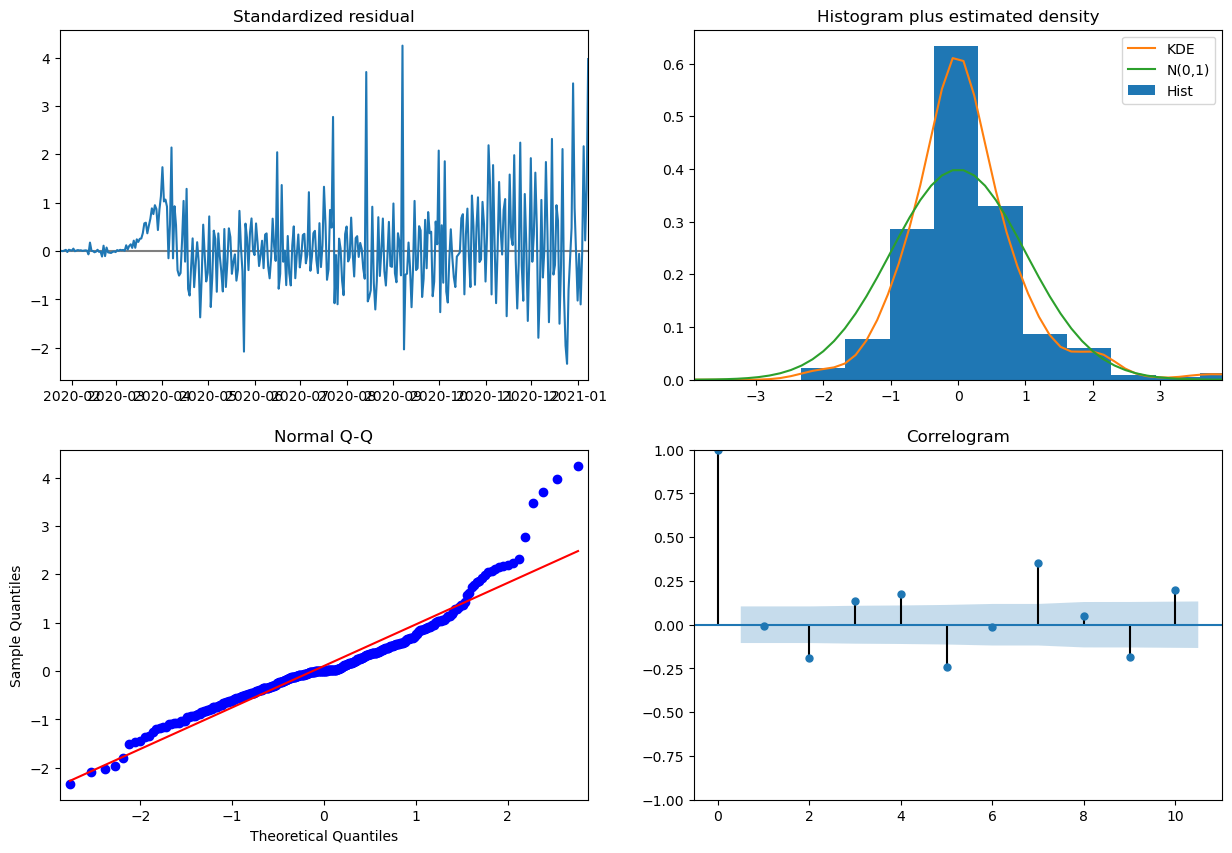

In [20]:
# ARIMA Model Evaluation

plt.rcParams.update(plt.rcParamsDefault)
results.plot_diagnostics(figsize = (15, 10));

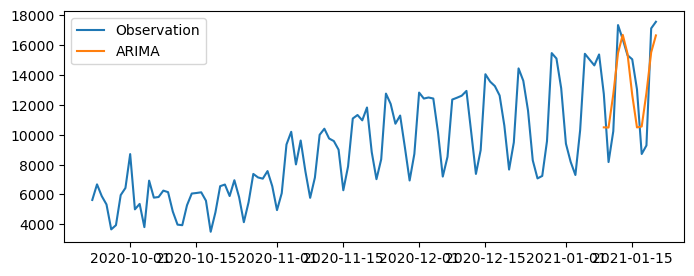

In [21]:
sarimax_prediction = results.predict(start = test.index[0], end = test.index[-1], dynamic = False)
plt.figure(figsize=(8, 3))
l1, = plt.plot(dataset.tail(120), label = 'Observation')
l2, = plt.plot(sarimax_prediction, label = 'ARIMA')
plt.legend(handles = [l1, l2])

In [22]:
print('SARIMAX RMSE = ', sqrt(mean_squared_error(sarimax_prediction, test)))

SARIMAX RMSE =  2067.1515224278314


## Predicción con Facebook Prophet

Prophet a diferencia de SARIMAX, espera que el data frame tenga dos columnas 'ds' e 'y'. 

In [23]:
train['ds'] = train.index.values

In [25]:
# Hyperparameter - Optimization

def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m = Prophet(**param_dict)
    m.fit(history_df)
    df_cv = cross_validation(m, initial='50 days', period='50 days', horizon = '50 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

param_grid = {  
                'changepoint_prior_scale': [0.001,0.01,0.05,0.5],
                'changepoint_range': [0.8, 0.9]
              }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results = []


params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(train,  metrics, param_dict)
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-14 00:00:00 and 2020-11-19 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-14 00:00:00 and 2020-11-19 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-14 00:00:00 and 2020-11-19 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-14 00:00:00 and 2020-11-19 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-14 00:00:00 and 2020-11-19 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-14 00:00:00 and 2020-11-19 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-14 00:00:00 and 2020-11-19 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-14 00:00:00 and 2020-11-19 00:00:00




 The best param combination is {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8}


,horizon,rmse,mape,params
0,27 days 12:00:00,3584.48,0.621065,"{'changepoint_prior_scale': 0.001, 'changepoin..."
1,27 days 12:00:00,3574.11,0.619221,"{'changepoint_prior_scale': 0.001, 'changepoin..."
2,27 days 12:00:00,3316.07,0.538854,"{'changepoint_prior_scale': 0.01, 'changepoint..."
3,27 days 12:00:00,3327.02,0.542948,"{'changepoint_prior_scale': 0.01, 'changepoint..."
4,27 days 12:00:00,3464.53,0.494505,"{'changepoint_prior_scale': 0.05, 'changepoint..."
5,27 days 12:00:00,3463.36,0.495855,"{'changepoint_prior_scale': 0.05, 'changepoint..."
6,27 days 12:00:00,2409.87,0.332635,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
7,27 days 12:00:00,2587.86,0.352286,"{'changepoint_prior_scale': 0.5, 'changepoint_..."


In [26]:
m = Prophet(changepoint_prior_scale = 0.5, changepoint_range = 0.8)
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
future = m.make_future_dataframe(periods = dataset.shape[0] - train.shape[0])
prophet_prediction = m.predict(future)

In [28]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= test.index[0]]

In [29]:
print('PROPHET RMSE = ', sqrt(mean_squared_error(prophet_future, test)))

PROPHET RMSE =  2433.3405833024285


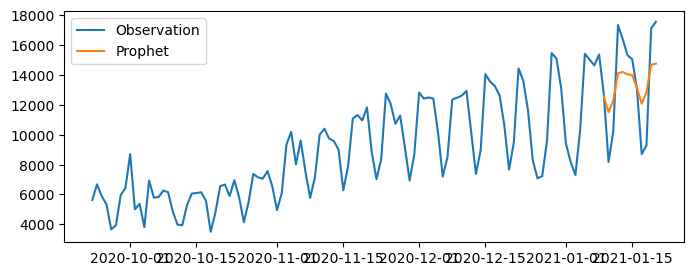

In [30]:
plt.figure(figsize=(8, 3))
l1, = plt.plot(dataset.tail(120), label = 'Observation')
l2, = plt.plot(prophet_future, label = 'Prophet')
plt.legend(handles=[l1, l2])

## Predicción con Exponential Smoothing

In [31]:
#Función que realiza Cross Validation para Exponential Smoothing

def timeseriesCVscore_exp_smoot(alpha, series):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # creamos un array de errores:
    errors = []
    
    values = series.values
    
    # instanciamos el objeto que realiza el tscv:
    tscv = TimeSeriesSplit(n_splits=5) 
    
    # Aplicamos cross validation:

    for train, test in tscv.split(values):
    
        model = ExponentialSmoothing(values[train]).fit(smoothing_level=alpha, optimized=False)
        
        predictions = model.forecast(len(test))
        actual = values[test]
    
        error = mean_squared_error(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [32]:
tscv = TimeSeriesSplit(n_splits=5)

In [33]:
alphas = [0.001, 0.01, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5, 0.7]
errors = []

for alpha in alphas:
    error = timeseriesCVscore_exp_smoot(alpha, train.y)
    errors.append(error)

print('Alpha óptimo:', alphas[np.argmin(errors)])

Alpha óptimo: 0.7


In [34]:
# Entrenamiento del modelo optimizado:

model_exp_smoothing = ExponentialSmoothing(train.y).fit(smoothing_level = alphas[np.argmin(errors)], optimized = False)

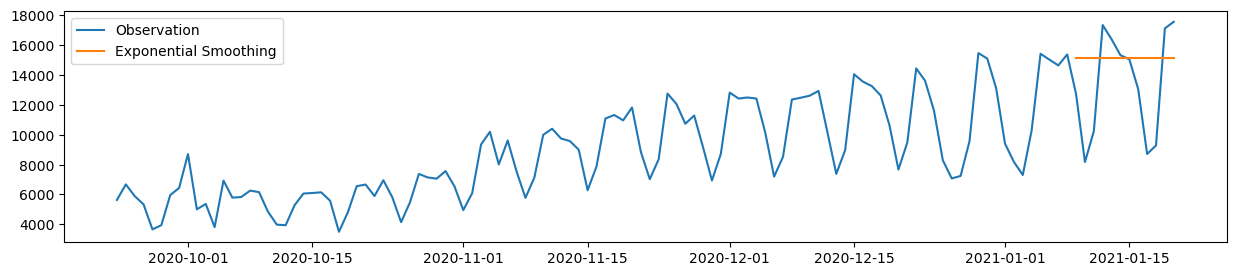

In [35]:
ES_prediction = model_exp_smoothing.forecast(12)
plt.figure(figsize=(15, 3))
l1, = plt.plot(dataset.tail(120), label = 'Observation')
l2, = plt.plot(ES_prediction, label = 'Exponential Smoothing')
plt.legend(handles=[l1, l2])

In [36]:
print('ES RMSE = ', sqrt(mean_squared_error(ES_prediction, test)))

ES RMSE =  3817.994474466491


## Preparación del dataset para SVR, XGBoost y NN

In [37]:
# Función que extrae los features del dataset

def featurize(t):
    X = pd.DataFrame()

    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    y = t.y
    return X, y

featurize(dataset_diff)[0].head()

,day,month,quarter,dayofweek,dayofyear,weekofyear
0,24,1,1,4,24,4
1,25,1,1,5,25,4
2,26,1,1,6,26,4
3,27,1,1,0,27,5
4,28,1,1,1,28,5


### Creación de training and test datasets dividiendo el dataset y estandarizar los datos

In [38]:
X_train, y_train = featurize(dataset_diff.loc[dataset_diff.index < test.index[0]])
X_test, y_test = featurize(dataset_diff.loc[dataset_diff.index >= test.index[0]])

In [39]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [40]:
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

## Predicción con SVR (Support Vector Regressor)

In [41]:
# Use scikit-learn to grid search C, gamma & kernel

param_grid = {'C': [0.1, 1, 5, 6, 7, 8, 9, 10, 15, 30, 50, 60, 65],  

              'gamma': ['auto','scale'], 

              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  

grid = GridSearchCV(SVR(), param_grid, scoring = 'r2', cv = tscv, n_jobs = -1, verbose = 3) 
grid.fit(scaled_train, y_train)

Fitting 5 folds for each of 104 candidates, totalling 520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 513 out of 520 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 520 out of 520 | elapsed:    6.3s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5, 6, 7, 8, 9, 10, 15, 30, 50, 60, 65],
                         'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='r2', verbose=3)

In [42]:
# print best parameter after tuning 

print(grid.best_params_) 
  
# print how the model looks after hyper-parameter tuning 

print(grid.best_estimator_) 

{'C': 65, 'gamma': 'auto', 'kernel': 'linear'}
SVR(C=65, gamma='auto', kernel='linear')


In [43]:
SVR_prediction = grid.predict(scaled_test)

In [44]:
print('SVR RMSE = ', sqrt(mean_squared_error(SVR_prediction, y_test)))

SVR RMSE =  3355.4160588700047


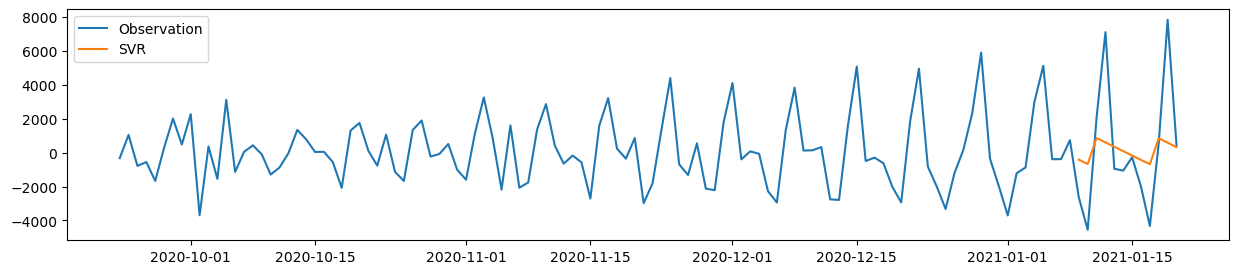

In [45]:
SVR_prediction = pd.DataFrame(SVR_prediction, index = test.index, columns = test.columns)
plt.figure(figsize=(15, 3))
l1, = plt.plot(dataset_diff.tail(120), label = 'Observation')
l2, = plt.plot(SVR_prediction, label = 'SVR')
plt.legend(handles=[l1, l2])

## Predicción con XGBOOST

In [46]:
# Use scikit-learn to grid search the max_depth & n_estimators

model = XGBRegressor()
n_estimators = [2, 3, 5, 7, 8, 9, 10]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth = max_depth, n_estimators = n_estimators)
grid = GridSearchCV(model, param_grid, scoring = 'r2', n_jobs = -1, cv = tscv, verbose = 1)
grid_result = grid.fit(scaled_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.1s


Best: 0.286602 using {'max_depth': 2, 'n_estimators': 9}
0.181022 (0.101083) with: {'max_depth': 2, 'n_estimators': 2}
0.220309 (0.116842) with: {'max_depth': 2, 'n_estimators': 3}
0.211823 (0.131706) with: {'max_depth': 2, 'n_estimators': 5}
0.248138 (0.145920) with: {'max_depth': 2, 'n_estimators': 7}
0.257882 (0.145280) with: {'max_depth': 2, 'n_estimators': 8}
0.286602 (0.150337) with: {'max_depth': 2, 'n_estimators': 9}
0.268262 (0.155448) with: {'max_depth': 2, 'n_estimators': 10}
0.133259 (0.171852) with: {'max_depth': 4, 'n_estimators': 2}
0.140340 (0.229284) with: {'max_depth': 4, 'n_estimators': 3}
0.209993 (0.210752) with: {'max_depth': 4, 'n_estimators': 5}
0.196189 (0.287880) with: {'max_depth': 4, 'n_estimators': 7}
0.208151 (0.282953) with: {'max_depth': 4, 'n_estimators': 8}
0.194957 (0.321031) with: {'max_depth': 4, 'n_estimators': 9}
0.201355 (0.319226) with: {'max_depth': 4, 'n_estimators': 10}
0.122187 (0.188998) with: {'max_depth': 6, 'n_estimators': 2}
0.122156 (0

[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.5s finished


In [47]:
XGBOOST_prediction = grid.predict(scaled_test)

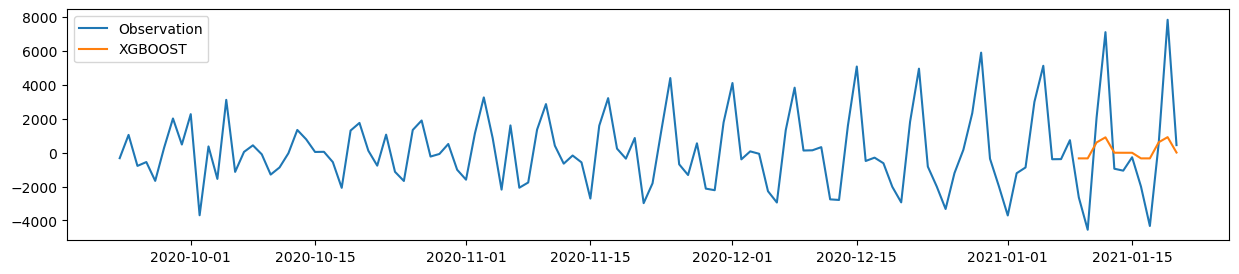

In [48]:
XGBOOST_prediction = pd.DataFrame(XGBOOST_prediction, index = test.index, columns = test.columns)
plt.figure(figsize=(15, 3))
l1, = plt.plot(dataset_diff.tail(120), label = 'Observation')
l2, = plt.plot(XGBOOST_prediction, label = 'XGBOOST')
plt.legend(handles=[l1, l2])

In [49]:
print('XGBOOST RMSE = ', sqrt(mean_squared_error(XGBOOST_prediction, y_test)))

XGBOOST RMSE =  3322.5513398876815


## Predicción con NN

In [50]:
NN_model = Sequential()
NN_model.add(Dense(20, input_shape = (scaled_train.shape[1],)))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_squared_error', optimizer = Adam(lr = 0.001))
NN_model.fit(scaled_train, y_train, validation_data = (scaled_test, y_test), epochs = 350, verbose = 1)
NN_prediction = NN_model.predict(scaled_test)

Epoch 1/350
11/11 [==============================] - 0s 26ms/step - loss: 2060576.2500 - val_loss: 14089368.0000
Epoch 2/350
11/11 [==============================] - 0s 5ms/step - loss: 2060183.8750 - val_loss: 14087789.0000
Epoch 3/350
11/11 [==============================] - 0s 5ms/step - loss: 2059785.6250 - val_loss: 14086115.0000
Epoch 4/350
11/11 [==============================] - 0s 6ms/step - loss: 2059356.2500 - val_loss: 14084339.0000
Epoch 5/350
11/11 [==============================] - 0s 6ms/step - loss: 2058898.3750 - val_loss: 14082363.0000
Epoch 6/350
11/11 [==============================] - 0s 7ms/step - loss: 2058383.0000 - val_loss: 14080149.0000
Epoch 7/350
11/11 [==============================] - 0s 6ms/step - loss: 2057812.2500 - val_loss: 14077657.0000
Epoch 8/350
11/11 [==============================] - 0s 6ms/step - loss: 2057174.3750 - val_loss: 14074835.0000
Epoch 9/350
11/11 [==============================] - 0s 6ms/step - loss: 2056433.2500 - val_loss: 14071

11/11 [==============================] - 0s 4ms/step - loss: 1538052.0000 - val_loss: 11412724.0000
Epoch 74/350
11/11 [==============================] - 0s 4ms/step - loss: 1530569.6250 - val_loss: 11344099.0000
Epoch 75/350
11/11 [==============================] - 0s 4ms/step - loss: 1522513.3750 - val_loss: 11282835.0000
Epoch 76/350
11/11 [==============================] - 0s 4ms/step - loss: 1514982.6250 - val_loss: 11227003.0000
Epoch 77/350
11/11 [==============================] - 0s 4ms/step - loss: 1508644.6250 - val_loss: 11170895.0000
Epoch 78/350
11/11 [==============================] - 0s 5ms/step - loss: 1503121.7500 - val_loss: 11110272.0000
Epoch 79/350
11/11 [==============================] - 0s 4ms/step - loss: 1497542.2500 - val_loss: 11054875.0000
Epoch 80/350
11/11 [==============================] - 0s 4ms/step - loss: 1491538.3750 - val_loss: 11003325.0000
Epoch 81/350
11/11 [==============================] - 0s 4ms/step - loss: 1487318.0000 - val_loss: 10947626.0

Epoch 145/350
11/11 [==============================] - 0s 5ms/step - loss: 1437693.5000 - val_loss: 10004936.0000
Epoch 146/350
11/11 [==============================] - 0s 5ms/step - loss: 1437714.1250 - val_loss: 10006443.0000
Epoch 147/350
11/11 [==============================] - 0s 5ms/step - loss: 1437853.2500 - val_loss: 10015523.0000
Epoch 148/350
11/11 [==============================] - 0s 5ms/step - loss: 1437601.2500 - val_loss: 10009696.0000
Epoch 149/350
11/11 [==============================] - 0s 5ms/step - loss: 1437538.1250 - val_loss: 10006515.0000
Epoch 150/350
11/11 [==============================] - 0s 5ms/step - loss: 1437560.3750 - val_loss: 10007156.0000
Epoch 151/350
11/11 [==============================] - 0s 5ms/step - loss: 1437623.1250 - val_loss: 9999166.0000
Epoch 152/350
11/11 [==============================] - 0s 3ms/step - loss: 1437440.3750 - val_loss: 9998989.0000
Epoch 153/350
11/11 [==============================] - 0s 3ms/step - loss: 1437375.2500 - 

11/11 [==============================] - 0s 4ms/step - loss: 1436132.1250 - val_loss: 9997693.0000
Epoch 218/350
11/11 [==============================] - 0s 3ms/step - loss: 1436048.6250 - val_loss: 10005408.0000
Epoch 219/350
11/11 [==============================] - 0s 4ms/step - loss: 1436068.5000 - val_loss: 10008207.0000
Epoch 220/350
11/11 [==============================] - 0s 4ms/step - loss: 1435940.5000 - val_loss: 10000374.0000
Epoch 221/350
11/11 [==============================] - 0s 4ms/step - loss: 1435937.1250 - val_loss: 10006525.0000
Epoch 222/350
11/11 [==============================] - 0s 4ms/step - loss: 1436026.7500 - val_loss: 10004213.0000
Epoch 223/350
11/11 [==============================] - 0s 6ms/step - loss: 1435860.0000 - val_loss: 10001705.0000
Epoch 224/350
11/11 [==============================] - 0s 5ms/step - loss: 1435782.1250 - val_loss: 10001362.0000
Epoch 225/350
11/11 [==============================] - 0s 5ms/step - loss: 1435763.8750 - val_loss: 100

11/11 [==============================] - 0s 4ms/step - loss: 1434869.1250 - val_loss: 9996233.0000
Epoch 289/350
11/11 [==============================] - 0s 4ms/step - loss: 1434840.5000 - val_loss: 10003070.0000
Epoch 290/350
11/11 [==============================] - 0s 4ms/step - loss: 1435144.3750 - val_loss: 10013804.0000
Epoch 291/350
11/11 [==============================] - 0s 4ms/step - loss: 1434673.3750 - val_loss: 10006369.0000
Epoch 292/350
11/11 [==============================] - 0s 4ms/step - loss: 1434826.0000 - val_loss: 10011423.0000
Epoch 293/350
11/11 [==============================] - 0s 3ms/step - loss: 1434666.1250 - val_loss: 10011118.0000
Epoch 294/350
11/11 [==============================] - 0s 4ms/step - loss: 1434593.6250 - val_loss: 10008852.0000
Epoch 295/350
11/11 [==============================] - 0s 4ms/step - loss: 1434730.8750 - val_loss: 10003747.0000
Epoch 296/350
11/11 [==============================] - 0s 4ms/step - loss: 1434654.0000 - val_loss: 100

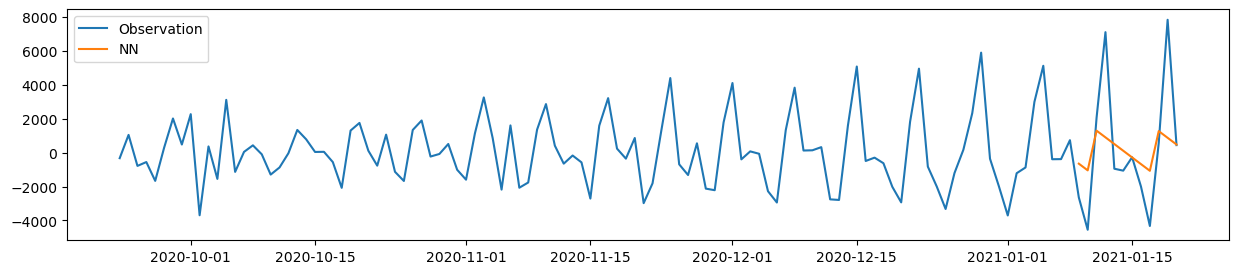

In [51]:
NN_prediction = pd.DataFrame(NN_prediction, index = test.index, columns = test.columns)
plt.figure(figsize=(15, 3))
l1, = plt.plot(dataset_diff.tail(120), label = 'Observation')
l2, = plt.plot(NN_prediction, label = 'NN')
plt.legend(handles=[l1, l2])

In [52]:
print('NN RMSE = ', sqrt(mean_squared_error(NN_prediction, y_test)))

NN RMSE =  3163.404894204699


## Comparación de los RMSE de cada modelo

In [53]:
df_results = pd.DataFrame(columns = ['Model', 'RMSE'])
df_results.loc[0, 'Model'] = 'SARIMAX'
df_results.loc[0, 'RMSE'] = round(sqrt(mean_squared_error(sarimax_prediction, test)),4)
df_results.loc[1, 'Model'] = 'Prophet'
df_results.loc[1, 'RMSE'] = round(sqrt(mean_squared_error(prophet_future, test)),4)
df_results.loc[2, 'Model'] = 'XGBOOST'
df_results.loc[2, 'RMSE'] = round(sqrt(mean_squared_error(XGBOOST_prediction, y_test)),4)
df_results.loc[3, 'Model'] = 'NN'
df_results.loc[3, 'RMSE'] = round(sqrt(mean_squared_error(NN_prediction, y_test)),4)
df_results.loc[4, 'Model'] = 'ES'
df_results.loc[4, 'RMSE'] = round(sqrt(mean_squared_error(ES_prediction, test)),4)
df_results.loc[5, 'Model'] = 'SVR'
df_results.loc[5, 'RMSE'] = round(sqrt(mean_squared_error(SVR_prediction, y_test)),4)
df_results.sort_values(by = 'RMSE', ascending = True)

,Model,RMSE
0,SARIMAX,2067.15
1,Prophet,2433.34
3,NN,3163.4
2,XGBOOST,3322.55
5,SVR,3355.42
4,ES,3817.99


## Visualización de las predicciones de cada modelo

<Figure size 2600x2300 with 0 Axes>

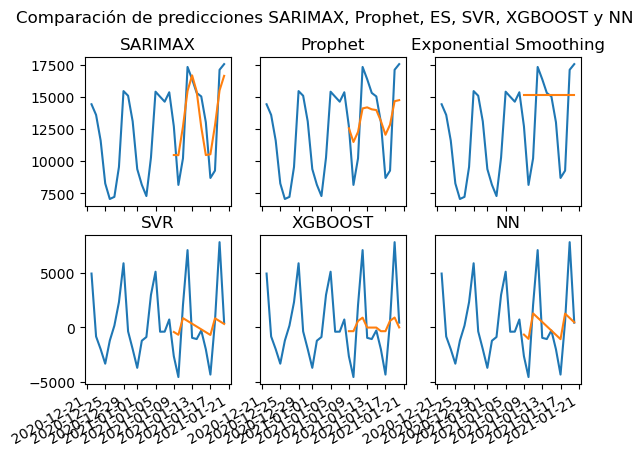

In [54]:
plt.figure(figsize=(26, 23))
fig, axs = plt.subplots(2, 3)
fig.suptitle('Comparación de predicciones SARIMAX, Prophet, ES, SVR, XGBOOST y NN')
axs[0, 0].plot(dataset.tail(30))
axs[0, 0].plot(sarimax_prediction.tail(30))
axs[0, 0].set_title('SARIMAX')
axs[0, 1].plot(dataset.tail(30))
axs[0, 1].plot(prophet_future.tail(30))
axs[0, 1].set_title('Prophet')
axs[0, 2].plot(dataset.tail(30))
axs[0, 2].plot(ES_prediction.tail(30))
axs[0, 2].set_title('Exponential Smoothing')
axs[1, 0].plot(dataset_diff.tail(30))
axs[1, 0].plot(SVR_prediction.tail(30))
axs[1, 0].set_title('SVR')
axs[1, 1].plot(dataset_diff.tail(30))
axs[1, 1].plot(XGBOOST_prediction.tail(30))
axs[1, 1].set_title('XGBOOST')
axs[1, 2].plot(dataset_diff.tail(30))
axs[1, 2].plot(NN_prediction.tail(30))
axs[1, 2].set_title('NN')

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

In [55]:
sarimax_prediction

2021-01-09    10487.552597
2021-01-10    10475.324205
2021-01-11    12697.481598
2021-01-12    15463.183864
2021-01-13    16675.210925
2021-01-14    15420.257825
2021-01-15    12657.099688
2021-01-16    10484.135250
2021-01-17    10545.838469
2021-01-18    12788.263372
2021-01-19    15505.385909
2021-01-20    16637.014749
Freq: D, dtype: float64